import kagglehub
import shutil
from pathlib import Path

### Kaggle에서 데이터 다운로드
path = kagglehub.dataset_download("googolples/cat-dog-images")

### Dog_Cat 폴더 정의
target_path = Path("../Dog_Cat")
target_path.mkdir(parents=True, exist_ok=True)  # 상위 디렉토리 생성

### 기존 Dog_Cat 폴더 삭제
if target_path.exists():
    shutil.rmtree(target_path)

### 하위 폴더로 복사
shutil.copytree(path, target_path / "data")  # 하위 폴더에 정리
print("Dataset moved to Dog_Cat/data folder:", target_path / "data")

Number of training samples: 5936
Number of testing samples: 2023
Classes: ['cats', 'dogs']


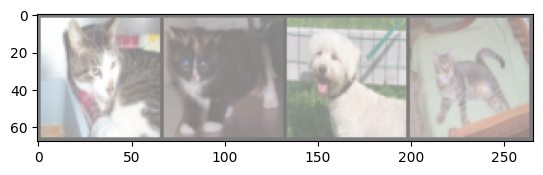

cats cats dogs cats


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F


# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),       
])

train_data = torchvision.datasets.ImageFolder(root='../Dog_Cat/dataset1/training_set/training_set', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = torchvision.datasets.ImageFolder(root='../Dog_Cat/dataset1/test_set/test_set', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 데이터 확인
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")
print(f"Classes: {train_data.classes}")  # 클래스 이름 출력

# 데이터 확인 (샘플 이미지 시각화)
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))  # 첫 4개 이미지 출력
print(' '.join(f'{train_data.classes[labels[j]]}' for j in range(4)))


In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# 모델 생성
model = SimpleCNN().to(device)

# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# 학습
num_epochs = 50
best_accuracy = 0
early_stopping_count = 0
patience = 10  # Early stopping patience

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

    # 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")

    # 학습률 감소 적용
    scheduler.step(avg_loss)

    # Early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        early_stopping_count = 0
        torch.save(model.state_dict(), "best_model.pth")  # 모델 저장
    else:
        early_stopping_count += 1

    if early_stopping_count >= patience:
        print("Early stopping triggered")
        break

print(f"Best Accuracy Achieved: {best_accuracy}%")

NameError: name 'ImprovedCNN' is not defined

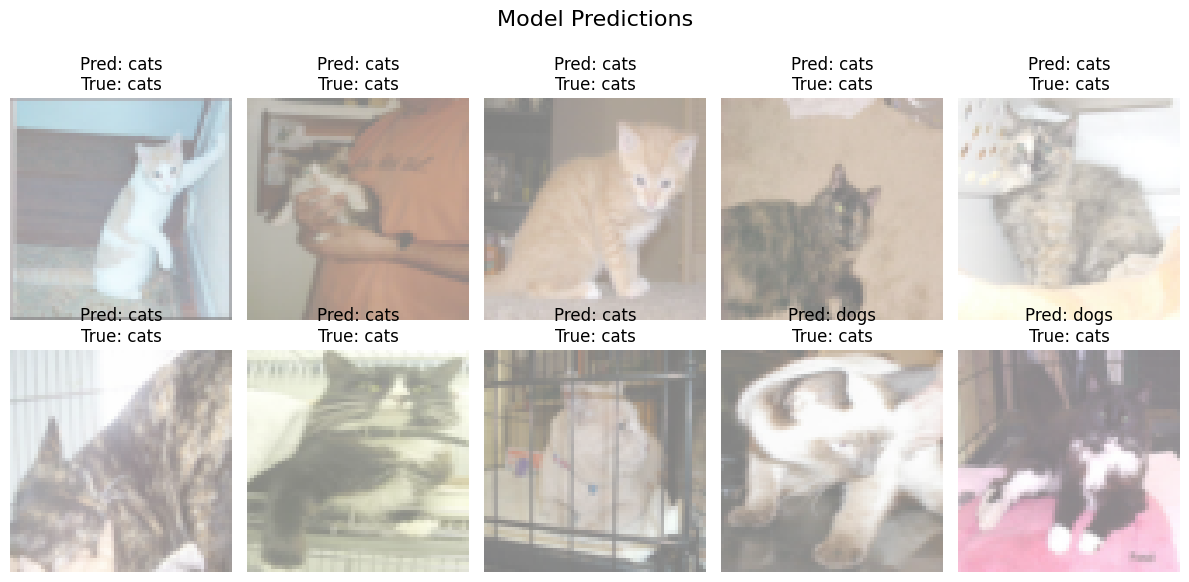

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름 정의 (사용하는 데이터셋에 맞게 수정)
class_names = train_loader.dataset.classes  

# 모델 예측값을 시각적으로 확인하는 함수
def imshow(img, ax, title):
    img = img / 2 + 0.5  # 정규화 되돌리기
    npimg = img.cpu().numpy()  # NumPy 배열 변환
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  # 차원 변환 (C, H, W) -> (H, W, C)
    ax.set_title(title, fontsize=12)  # 예측 결과를 제목으로 표시
    ax.axis("off")  # 축 숨기기

# 일부 테스트 샘플 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# 모델 예측 수행
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)  # 가장 높은 확률의 클래스 선택

# 이미지 및 예측 결과 출력
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # 2x5 레이아웃으로 이미지 배치
fig.suptitle("Model Predictions", fontsize=16)  # 전체 제목 설정

for i, ax in enumerate(axes.flat):
    if i < len(images):
        imshow(images[i], ax, f"Pred: {class_names[predicted[i].item()]}\nTrue: {class_names[labels[i].item()]}")

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # 제목과 이미지 간격 조정
plt.show()
